# Pythonによる分位点回帰 (Quantile regression)
> 

- toc: true 
- badges: true
- comments: true
- author: 山拓
- categories: [statistics]

Distributional Reinforcement Learningの理解のために必要だったのでメモとして残しておきます (本当はexpectile regressionも書かなければならないですが)。内容としてはNumpyで勾配法により分位点回帰をする、というものになっています。

## 分位点回帰 (Quantile Regression)とは
通常の最小二乗法による線形回帰(Ordinary least squares regression)は、誤差が正規分布と仮定したときのX(説明変数)に対するY(目的変数)の期待値E[Y]を求めます。これに対して**分位点回帰(quantile regression)**では、Xに対するYの分布における分位点を通るような直線を引きます。

**分位点**(または分位数)についてですが、簡単なのが**四分位数**です。箱ひげ図などで出てきますが、例えば第一四分位数は分布を25:75に分ける数、第二四分位数(中央値)は分布を50:50に分ける数です。同様に$q$分位数($q$-quantile)というと分布を$q:1-q$に分ける数となっています。

さて、分位点回帰に戻りましょう。下図は$x\sim U(0, 5),\quad y=3x+x\cdot \xi,\quad \xi\sim N(0,1)$とした500個の点に対する分位点回帰です(コードは図の下にあります)。青い領域はX=1,2,3,4でのYの分布を示しています。紫、緑、黄色の直線はそれぞれ10, 50,
90%tile回帰の結果です。例えば50%tile回帰の結果は、Xが与えられたときのYの中央値(50%tile点)を通るような直線となっています。同様に90%tile回帰の結果は90%tile点を通るような直線となっています。

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


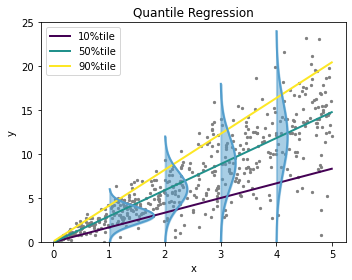

In [1]:
#collapse-hide

import numpy as np
np.random.seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm
 
def QuantileGradientDescent(X, y, init_theta, tau, lr=1e-4, num_iters=10000):
    theta = init_theta
    for i in range(num_iters):
        y_hat = X @ theta # predictions
        delta = y - y_hat  # error
        indic = np.array(delta <= 0., dtype=np.float32) # indicator
        grad = np.abs(tau - indic) * np.sign(delta) # gradient
        theta += lr * X.T @ grad # Update
    return theta
 
def gaussian_func(x, mu, sigma):
    return (0.8/sigma)*np.exp( - (x - mu)**2 / (2 * sigma**2))
 
cmap = plt.cm.viridis(np.linspace(0., 1., 3))
 
# Generate Toy datas
N = 500 # sample size
x = np.random.rand(N)*5
y = 3*x + x*np.random.randn(N)
 
X = np.ones((N, 2)) # design matrix
X[:, 1] = x 
 
taus = np.array([0.1, 0.5, 0.9])
m = len(taus) 
Y = np.zeros((m, N)) # memory array
 
for i in tqdm(range(m)):
    init_theta = np.zeros(2) # init variables
    theta = QuantileGradientDescent(X, y, init_theta, tau=taus[i])
    y_hat = X @ theta
    Y[i] = y_hat
 
# Results plot
plt.figure(figsize=(5,4))
plt.title("Quantile Regression")
plt.scatter(x, y, color="gray", s=5) # samples

for i in range(m):
    plt.plot([min(x), max(x)], [min(Y[i]), max(Y[i])], linewidth=2,
              color=cmap[i], label=str(int(taus[i]*100))+"%tile")  # regression line
 
for loc in range(1,5):
    noise_y = np.arange(0, 6*loc, 1e-3)
    noise_x = loc + gaussian_func(noise_y, 3*loc, loc)
    plt.fill_between(noise_x, -1, noise_y, color='#539ecd',
                     linewidth=2, alpha=0.5)
    plt.plot(noise_x, noise_y, color='#539ecd', linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0, 25)
plt.legend()
plt.tight_layout()
plt.show()

分位点回帰の利点としては、外れ値に対して堅牢(ロバスト)である、Yの分布が非対称である場合にも適応できる、などがあります ([Das et al., *Nat Methods*. 2019](https://www.nature.com/articles/s41592-019-0406-y))。

それでは分位点回帰をPythonで行う方法を見ていきましょう。

## 勾配法による線形回帰 (最小二乗法)

最小二乗法による線形回帰と異なり、分位点回帰は解析的に求めることができません。そのため、数値的に勾配法で求めるのですが、一先ずは最小二乗法による回帰直線を勾配法で求めてみましょう。

簡単のために単回帰の場合を考えます。パラメータを$\theta \in \mathbb{R}^2$, サンプルサイズを$n$, 説明変数の計画行列を$n \times 2$の行列$X$, 目的変数を$y \in \mathbb{R}^n$とします。ただし$X$と$y$は観測値です。$y$の予測値は$X \theta$なので、誤差 $\delta \in \mathbb{R}^n$は
$$\delta = y-X \theta$$ と表せます (符号は逆のことが多いですが)。最小二乗法において最適化したい目的関数は$$L(\delta)=\sum_{i=1}^n \delta_i^2 = \|\delta\|^2=\delta^T \delta$$ であり、$$\frac{\partial L}{\partial \theta}=-\frac{1}{n} \delta X$$
と表せるので、$\theta$の更新式は$\theta \leftarrow \theta + \alpha\cdot \dfrac{1}{n} \delta X$と書けます ($\alpha$は学習率です)。

さて、これを実装したコードと結果は次のようになります。

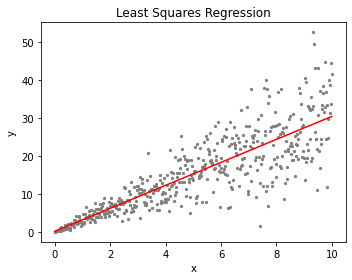

In [2]:
#collapse-hide

# Ordinary least squares regression
def OLSRegGradientDescent(X, y, init_theta, lr=1e-4, num_iters=10000):
    theta = init_theta
    for i in range(num_iters):
        y_hat = X @ theta # predictions
        delta = y - y_hat  # error
        theta += lr * delta @ X # Update
    return theta
 
# Generate Toy datas
N = 500 # sample size
x = np.linspace(0, 10, N)
y = 3*x + x*np.random.randn(N)
 
X = np.ones((N, 2)) # design matrix
X[:, 1] = x 
 
# Gradient descent
init_theta = np.zeros(2) # init variables
 
lr = 1e-4 # learning rate
num_iters = 1000 # training iterations
theta = OLSRegGradientDescent(X, y, init_theta)
y_hat = X @ theta # predictions
 
# Results plot
plt.figure(figsize=(5,4))
plt.title("Least Squares Regression")
plt.scatter(x, y, color="gray", s=5) # samples
plt.plot([min(x), max(x)], [min(y_hat), max(y_hat)],
          color='red')  # regression line
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

上図において赤色の線が回帰直線です。今回は誤差を正規分布としているので綺麗な結果ですが、実際には外れ値の影響を受けたりします。

## 勾配法による分位点回帰

本題の分位点回帰です。前節と同様の設定とします。ここで $\delta$の関数を $$\rho_{\tau}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right|\cdot |\delta|=\left(\tau-\mathbb{I}_{\delta \leq 0}\right)\cdot \delta$$
とします。ただし、$\tau$は関心のある分位点(quantile)、$\mathbb{I}$は指示関数(indicator function)です。この場合、$\mathbb{I}_{\delta \leq 0}$は$\delta \gt 0$なら0, $\delta \leq 0$なら1となります。このとき、分位点回帰の目的関数は $$L_{\tau}(\delta)
=\sum_{i=1}^n \rho_{\tau}(\delta_i)$$ です。なぜこの目的関数の最適化が$\tau$-分位点の回帰となるかについては[Quantile regressionのWikipedia](https://en.wikipedia.org/wiki/Quantile_regression)に詳細に書いてあります。また、$\rho_{\tau}(\delta)$を色々な $\tau$についてplotすると次図のようになります。

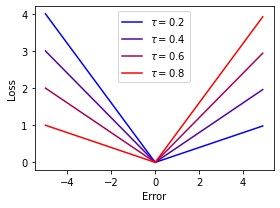

In [3]:
#collapse-hide

delta = np.arange(-5, 5, 0.1)
tau= np.arange(0.2, 1.0, 0.2)
cmap = plt.cm.brg(np.linspace(0, 0.5, len(tau)))
 
plt.figure(figsize=(4,3))
for i in range(len(tau)):
    indic = delta <= 0
    y = (tau[i]-indic)*delta
    plt.plot(delta, y, label=r"$\tau=$"+"{0:.1f}".format(tau[i]),
             color=cmap[i])
plt.xlabel("Error")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

それでは$L_\tau$を最小化するような$\theta$の更新式について考えていきましょう。まず、$$\frac{\partial \rho_{\tau}(\delta)}{\partial \delta}=\rho_{\tau}^{\prime}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot
\operatorname{sign}(\delta)$$ です (ただしsignは符号関数)。さらに$$\frac{\partial L_{\tau}}{\partial \theta}=\frac{\partial L_{\tau}}{\partial \delta}\frac{\partial \delta(\theta)}{\partial \theta}=-\frac{1}{n}
\rho_{\tau}^{\prime}(\delta) X$$ が成り立つので、$\theta$の更新式は$\theta \leftarrow \theta + \alpha\cdot \dfrac{1}{n} \rho_{\tau}^{\prime}(\delta) X$と書けます ($\alpha$は学習率です)。ゆえに実装には前節のコードを少し修正すればよいです。

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


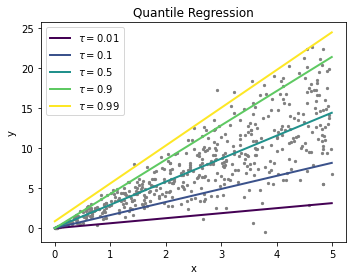

In [4]:
#collapse-hide

def QuantileRegGradientDescent(X, y, init_theta, tau, lr=1e-4, num_iters=10000):
    theta = init_theta
    for i in range(num_iters):
        y_hat = X @ theta # predictions
        delta = y - y_hat  # error
        indic = np.array(delta <= 0., dtype=np.float32) # indicator
        grad = np.abs(tau - indic) * np.sign(delta) # gradient
        theta += lr * grad @ X # Update
    return theta
 
cmap = plt.cm.viridis(np.linspace(0., 1., 5))
 
# Generate Toy datas
N = 500 # sample size
x = np.random.rand(N)*5
y = 3*x + x*np.random.randn(N)
 
X = np.ones((N, 2)) # design matrix
X[:, 1] = x 
 
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
Y = np.zeros((m, N)) # memory array
 
for i in tqdm(range(m)):
    init_theta = np.zeros(2) # init variables
    theta = QuantileRegGradientDescent(X, y, init_theta, tau=taus[i])
    y_hat = X @ theta # prediction
    Y[i] = y_hat # memory
     
# Results plot
plt.figure(figsize=(5,4))
plt.title("Quantile Regression")
plt.scatter(x, y, color="gray", s=5) # samples
for i in range(m):
    plt.plot([min(x), max(x)], [min(Y[i]), max(Y[i])], linewidth=2,
              color=cmap[i], label=r"$\tau=$"+str(taus[i]))  # regression line
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

ただし、分位点回帰を単純な勾配法で求める場合、勾配が0となって解が求まらない可能性があるので避けた方が良いという話はあります。そのために、目的関数を滑らかにするという研究もあります ([Zheng. *IJMLC*. 2011](https://link.springer.com/article/10.1007/s13042-011-0031-2))。

## Statsmodelsによる分位点回帰

前節のように分位点回帰は実装できますが、より簡単かつ高速に行うにはライブラリを用いるのがよいです。Statsmodelには分位点回帰のモデルがあり、それを最適化するだけで回帰直線が得られます。

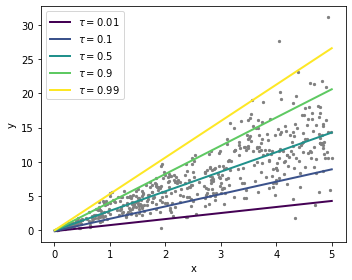

In [5]:
#collapse-hide

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
 
cmap = plt.cm.viridis(np.linspace(0., 1., 5))
 
# Generate Toy datas
N = 500 # sample size
x = np.random.rand(N)*5
y = 3*x + x*np.random.randn(N)
 
X = sm.add_constant(x)
model = QuantReg(y, X)
 
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
Y = np.zeros((m, N)) # memory array
 
for i in range(m):    
    results = model.fit(q=taus[i])
    y_hat = X @ results.params
    Y[i] = y_hat
 
plt.figure(figsize=(5,4))
plt.scatter(x, y, color="gray", s=5) # samples
for i in range(m):
    plt.plot([min(x), max(x)], [min(Y[i]), max(Y[i])], linewidth=2,
              color=cmap[i], label=r"$\tau=$"+str(taus[i]))  # regression line
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## 参考文献
- https://en.wikipedia.org/wiki/Quantile_regression
- Das, K., Krzywinski, M. & Altman, N. Quantile regression. Nat Methods 16, 451–452 (2019) doi:[10.1038/s41592-019-0406-y](https://www.nature.com/articles/s41592-019-0406-y)
- Quantile and Expectile Regressions ([pdf](https://freakonometrics.hypotheses.org/files/2017/05/erasmus-1.pdf))